In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Read Data

In [2]:
weather14 = pd.read_csv('data/weather/aus14-16.csv')
weather16 = pd.read_csv('data/weather/aus16-18.csv')
weather18 = pd.read_csv('data/weather/aus18-20.csv')
weather20 = pd.read_csv('data/weather/aus20-22.csv')
weather22 = pd.read_csv('data/weather/aus22-24.csv')
weather24 = pd.read_csv('data/weather/aus24.csv')

In [3]:
weather_all = pd.concat([weather14, weather16, weather18, weather20, weather22, weather24]).reset_index(drop=True)
weather_all['datetime'] = pd.to_datetime(weather_all['datetime'])
weather_all = weather_all.set_index('datetime')
weather_all = weather_all[~weather_all.index.duplicated(keep='first')]

In [4]:
cutoff = '2024-03-22'
weather = weather_all[:cutoff]

In [5]:
weather.columns

Index(['name', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [6]:
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'precip','snow', 'snowdepth', 'windspeed', 'conditions', 'description']
weather_f = weather[features]

In [7]:
def to_metric(df):
    df.loc[:, ['tempmax', 'tempmin', 'temp']] = (df.loc[:, ['tempmax', 'tempmin', 'temp']] - 32) * 5/9
    df.loc[:, ['precip', 'snow', 'snowdepth']] = df.loc[:, ['precip', 'snow', 'snowdepth']] * 25.4
    df.loc[:, 'windspeed'] = df.loc[:, 'windspeed'] * 1.60934
    df.loc[:, 'conditions'] = df.loc[:, 'conditions'].str.lower()
    df.loc[:, 'raining'] = df['conditions'].str.contains('rain').astype(int)
    df.loc[:, 'snowing'] = df['conditions'].str.contains('snow').astype(int)

to_metric(weather_f)


C:\Users\Acer\AppData\Local\Temp\ipykernel_8324\3060326518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'raining'] = df['conditions'].str.contains('rain').astype(int)
C:\Users\Acer\AppData\Local\Temp\ipykernel_8324\3060326518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'snowing'] = df['conditions'].str.contains('snow').astype(int)


In [8]:
weather_all = weather_all[features]
to_metric(weather_all)

## Heavy Weather Function

In [9]:
precip_threshold = weather_f['precip'].quantile(0.95)
snow_threshold = 10
windspeed_threshold = 45
tempmax_threshold = 35
tempmin_threshold = -3
humidity_threshold = 90

heavy rain with threshold p95, heavy snowfall with threshold 10 mm, heavy wind at over 45 kph, maxtemp over 32, mintemp  -3

In [10]:
weather_f.loc[:, 'heavy_weather'] = (
    (weather_f['precip'] > precip_threshold) |
    (weather_f['snow'] > snow_threshold) |
    (weather_f['windspeed'] > windspeed_threshold) |
    (weather_f['tempmax'] > tempmax_threshold) |
    (weather_f['tempmin'] < tempmin_threshold) |
    (weather_f['humidity'] > humidity_threshold)
).astype(int)

C:\Users\Acer\AppData\Local\Temp\ipykernel_8324\3317382555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_f.loc[:, 'heavy_weather'] = (


In [11]:
weather_all.loc[:, 'heavy_weather'] = (
    (weather_all['precip'] > precip_threshold) |
    (weather_all['snow'] > snow_threshold) |
    (weather_all['windspeed'] > windspeed_threshold) |
    (weather_all['tempmax'] > tempmax_threshold) |
    (weather_all['tempmin'] < tempmin_threshold) |
    (weather_all['humidity'] > humidity_threshold)
).astype(int)

In [12]:
len(weather_f.loc[weather_f['heavy_weather']==1])

565

In [24]:
weather_all

,tempmax,tempmin,temp,humidity,precip,snow,snowdepth,windspeed,conditions,description,raining,snowing,heavy_weather
datetime,,,,,,,,,,,,,
2014-01-01,26.000000,10.555556,18.944444,57.3,0.0000,NaN,NaN,22.369826,partially cloudy,Partly cloudy throughout the day.,0,0,0
2014-01-02,26.055556,16.944444,22.944444,41.5,0.0000,NaN,NaN,40.716302,partially cloudy,Partly cloudy throughout the day.,0,0,0
2014-01-03,34.000000,17.111111,23.888889,48.8,0.0000,NaN,NaN,33.474272,partially cloudy,Partly cloudy throughout the day.,0,0,0
2014-01-04,25.500000,15.944444,21.000000,33.6,0.0000,NaN,NaN,35.244546,clear,Clear conditions throughout the day.,0,0,0
2014-01-05,27.833333,7.000000,19.277778,38.8,0.0000,NaN,NaN,37.014820,clear,Clear conditions throughout the day.,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-27,24.666667,10.444444,17.277778,63.2,6.8072,NaN,NaN,26.715044,partially cloudy,NaN,0,0,0
2024-11-28,26.055556,11.833333,18.666667,61.3,4.8006,NaN,NaN,28.807186,partially cloudy,NaN,0,0,0
2024-11-29,25.666667,12.333333,18.833333,60.1,5.4102,NaN,NaN,27.036912,partially cloudy,NaN,0,0,0


<Axes: xlabel='datetime'>

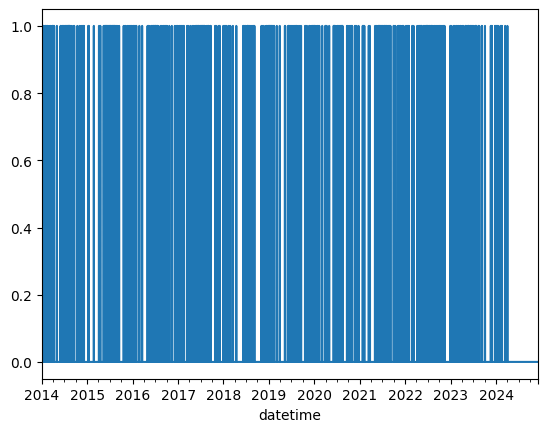

In [13]:
weather_all['heavy_weather'].plot()

<Axes: xlabel='datetime'>

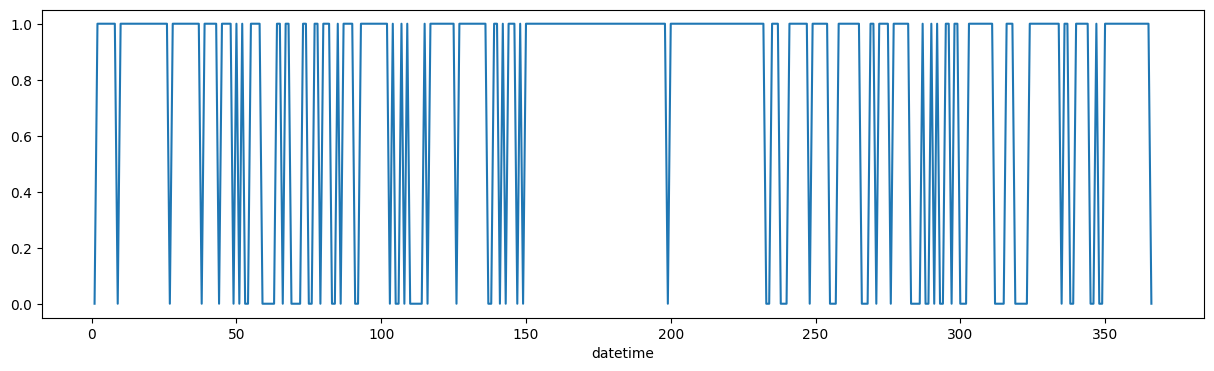

In [14]:
plt.figure(figsize=(15,4))
weather_f.groupby(by=weather_f.index.dayofyear)['heavy_weather'].sum().apply(lambda x: 1 if x>0 else 0).plot()

In [25]:
weather_all.to_csv('data/weather/weather_all.csv')

In [15]:
weather_clean = weather_f.drop(columns=['temp','snowdepth','conditions','description','raining', 'snowing', 'heavy_weather'])

<Axes: >

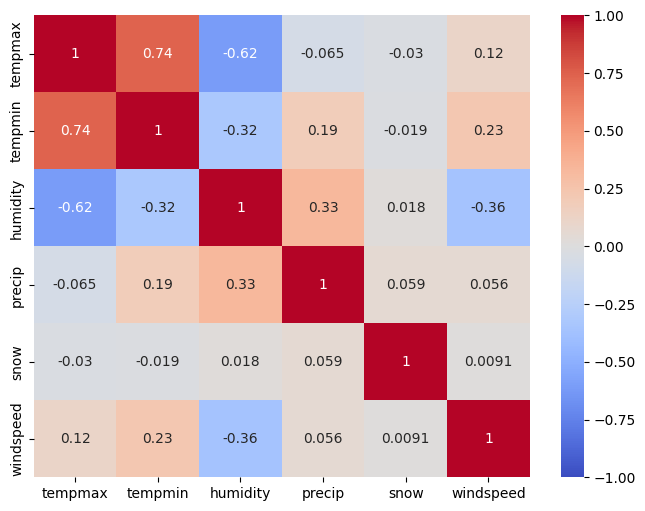

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(weather_clean.corr(), vmin=-1,vmax=1,annot=True,cmap='coolwarm')

## Forecast

In [17]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' , result[4])

In [18]:
forecast_features = ['tempmax', 'tempmin', 'humidity', 'precip', 'snow', 'windspeed']
for feature in forecast_features:
    print(f'Dickey Fuller test for feature {feature}')
    perform_dickey_fuller_test(weather_clean[feature])

Dickey Fuller test for feature tempmax
Test statistic:  -3.787982065935709
Critical Values: {'1%': -3.4321114600792098, '5%': -2.862318315640672, '10%': -2.567184308512469}
Dickey Fuller test for feature tempmin
Test statistic:  -4.013458590121994
Critical Values: {'1%': -3.432110037799655, '5%': -2.8623176873805285, '10%': -2.567183974048875}
Dickey Fuller test for feature humidity
Test statistic:  -4.758145969272209
Critical Values: {'1%': -3.4321138356601963, '5%': -2.8623193649997063, '10%': -2.567184867154409}
Dickey Fuller test for feature precip
Test statistic:  -39.84817839080911
Critical Values: {'1%': -3.4321034307501512, '5%': -2.8623147688604362, '10%': -2.567182420332135}
Dickey Fuller test for feature snow


MissingDataError: exog contains inf or nans

Conclude that :  
1. tempmax is **stationary**
2. tempmin is **stationary**
3. humidity is **stationary**
4. precip is **stationary**
5. snow is **stationary**
6. windspeed is **stationary**

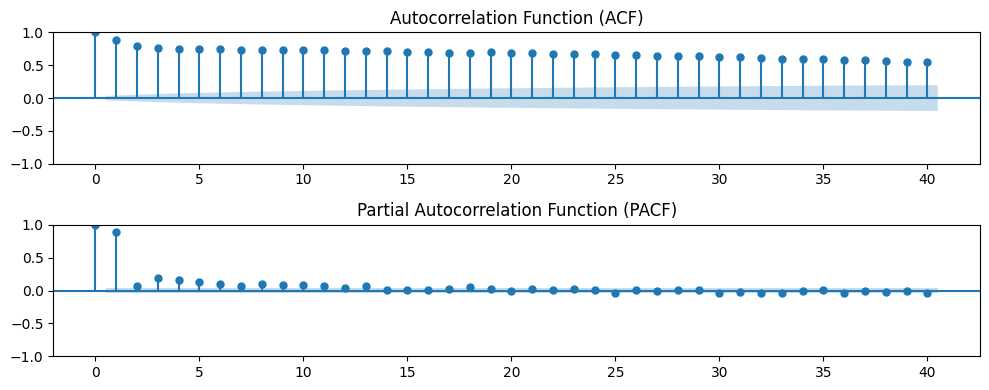

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

# ACF plot
plot_acf(weather_clean['tempmax'], lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(weather_clean['tempmax'], lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [20]:
weather_clean

,tempmax,tempmin,humidity,precip,snow,windspeed
datetime,,,,,,
2014-01-01,26.000000,10.555556,57.3,0.0000,NaN,22.369826
2014-01-02,26.055556,16.944444,41.5,0.0000,NaN,40.716302
2014-01-03,34.000000,17.111111,48.8,0.0000,NaN,33.474272
2014-01-04,25.500000,15.944444,33.6,0.0000,NaN,35.244546
2014-01-05,27.833333,7.000000,38.8,0.0000,NaN,37.014820
...,...,...,...,...,...,...
2024-03-18,22.666667,14.777778,80.7,0.5080,0.0,19.955816
2024-03-19,28.944444,15.166667,65.5,0.0000,0.0,20.599552
2024-03-20,22.944444,10.944444,66.4,3.1242,0.0,25.910374


In [21]:
from sklearn.metrics import mean_absolute_error

Forecasting feature tempmax


c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


4.55209730536535


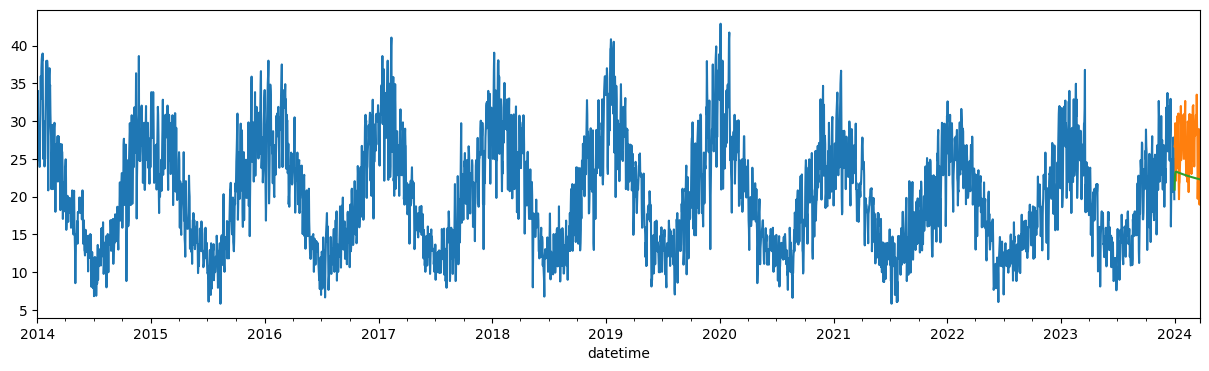

Forecasting feature tempmin
3.2336721859400583


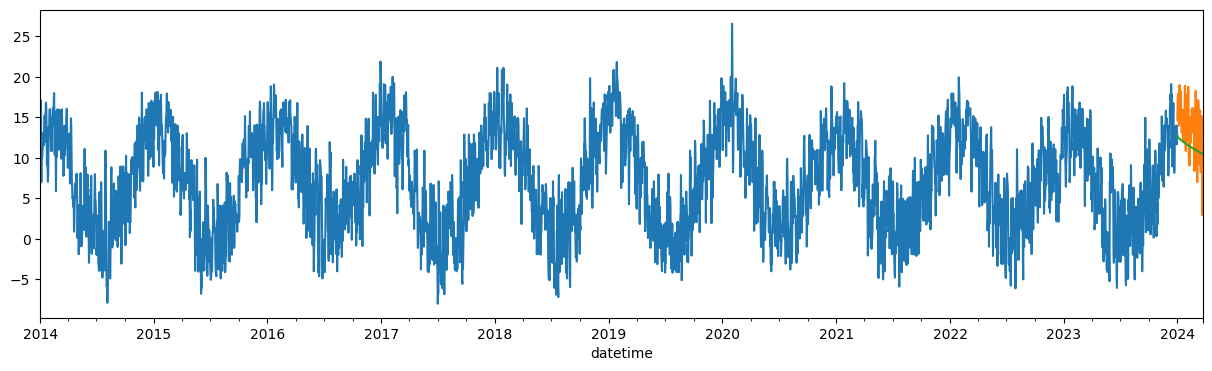

Forecasting feature humidity
7.010558354503906


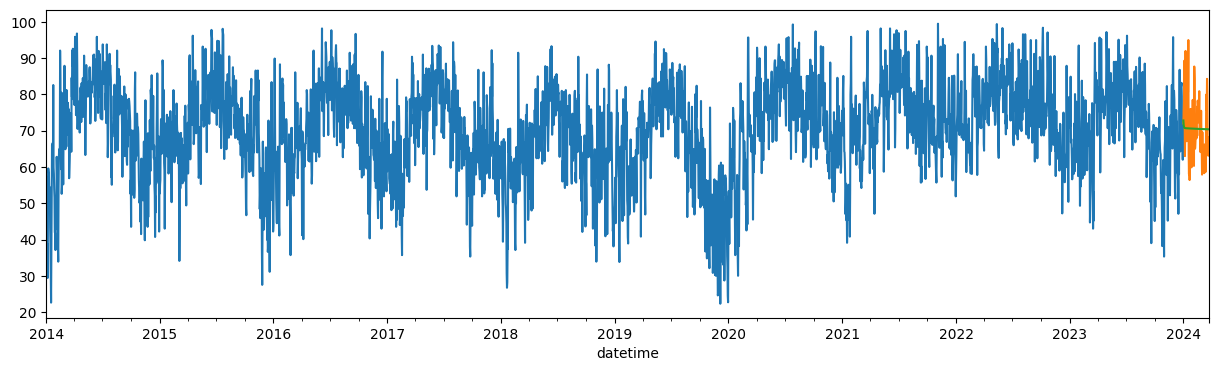

Forecasting feature precip
2.741131302092959


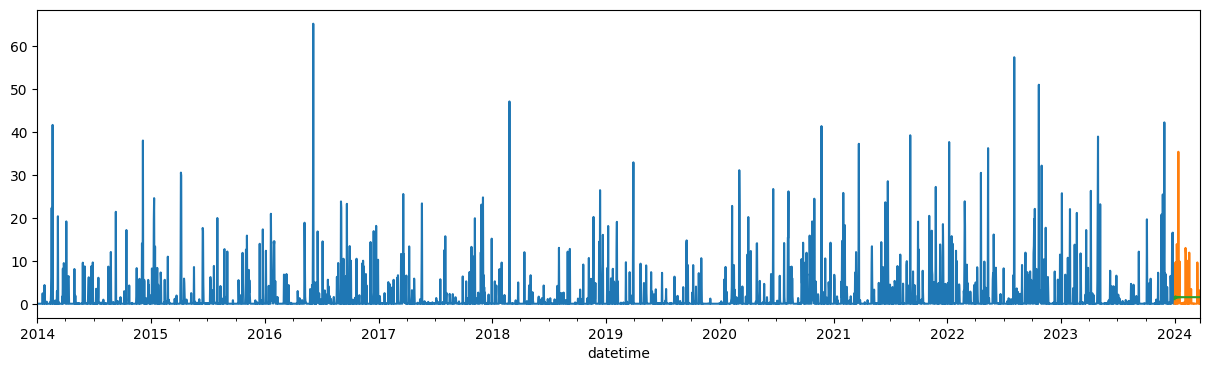

Forecasting feature snow
0.018542271894965885


c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Acer\anaconda3\envs\angusta\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


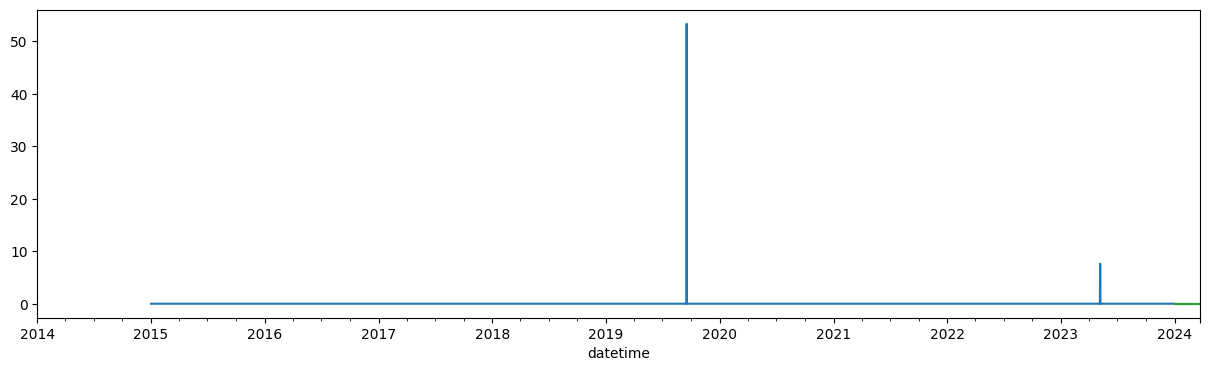

Forecasting feature windspeed
4.421384173474451


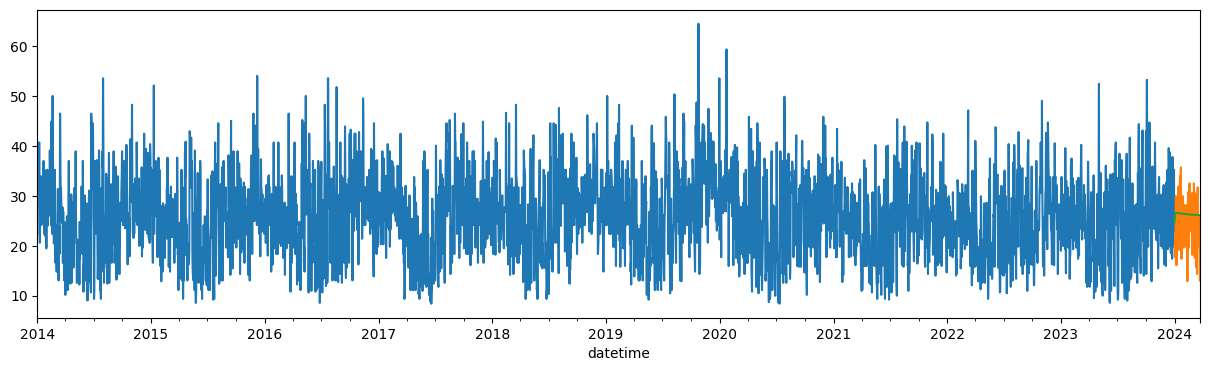

In [22]:
arima_dict = {}
for feature in forecast_features:
    print(f'Forecasting feature {feature}')
    train_series = weather_clean[feature][:'2023-12-31']
    train_series.index = pd.DatetimeIndex(train_series.index).to_period('D')
    test_series = weather_clean[feature]['2024-01-01':]
    test_series.index = pd.DatetimeIndex(test_series.index).to_period('D')
    model = ARIMA(train_series, order=(2, 0, 2))
    model_fit = model.fit()
    
    forecast_steps = 82  # Forecast for 365 days
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast.index = test_series.index
    mae = mean_absolute_error(forecast, test_series)
    arima_dict[feature] = mae
    print(mae)
    
    plt.figure(figsize=(15,4))
    train_series.plot()
    test_series.plot()
    forecast.plot()
    plt.show()
    

Forecasting feature tempmax
Mean Absolute Error: 7.64191918476976


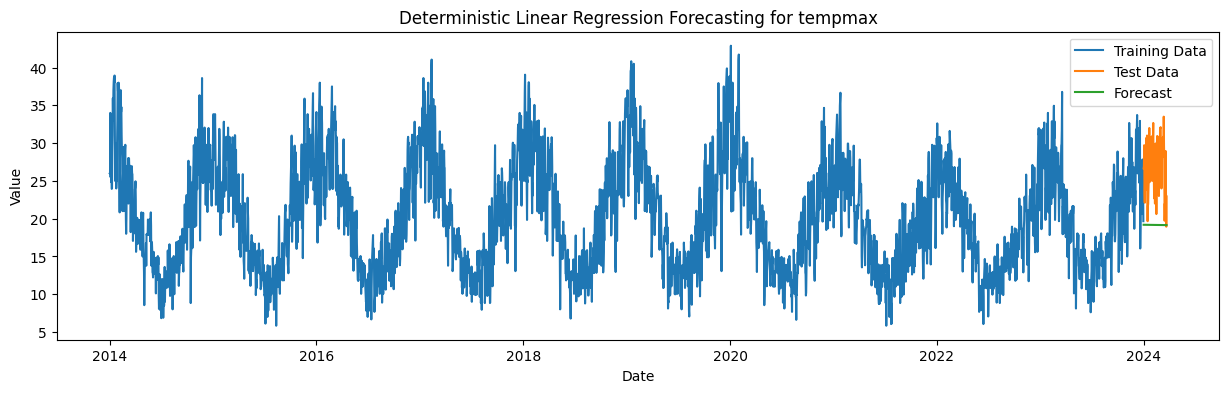

Forecasting feature tempmin
Mean Absolute Error: 7.206845331580945


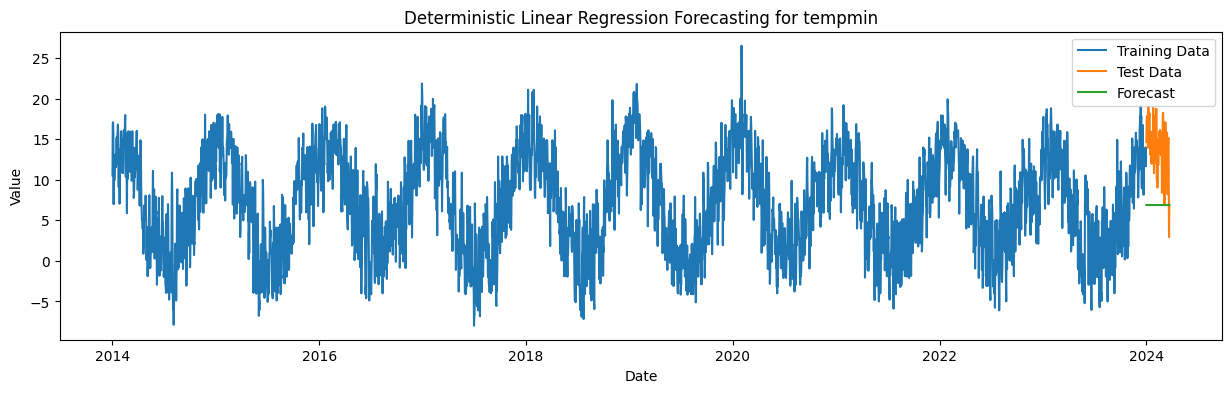

Forecasting feature humidity
Mean Absolute Error: 7.51320565764806


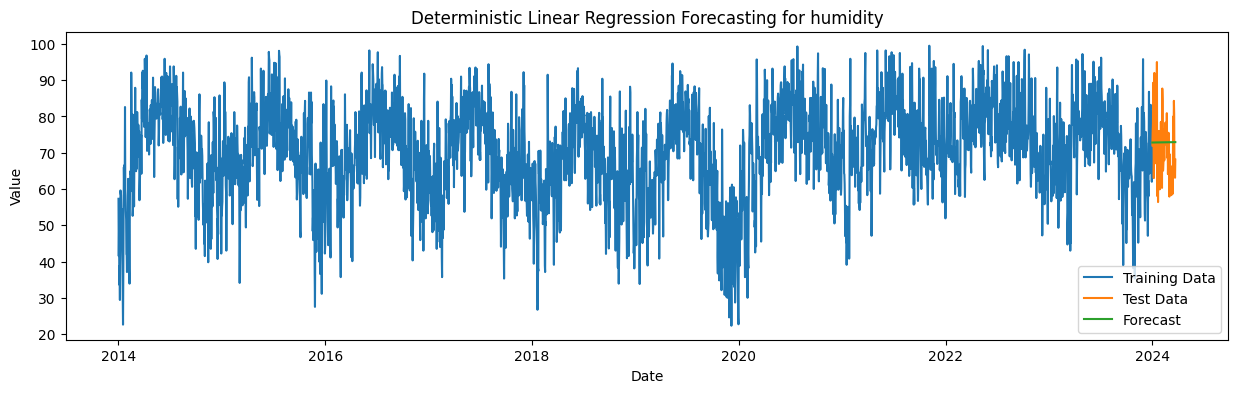

Forecasting feature precip
Mean Absolute Error: 2.9910059406700293


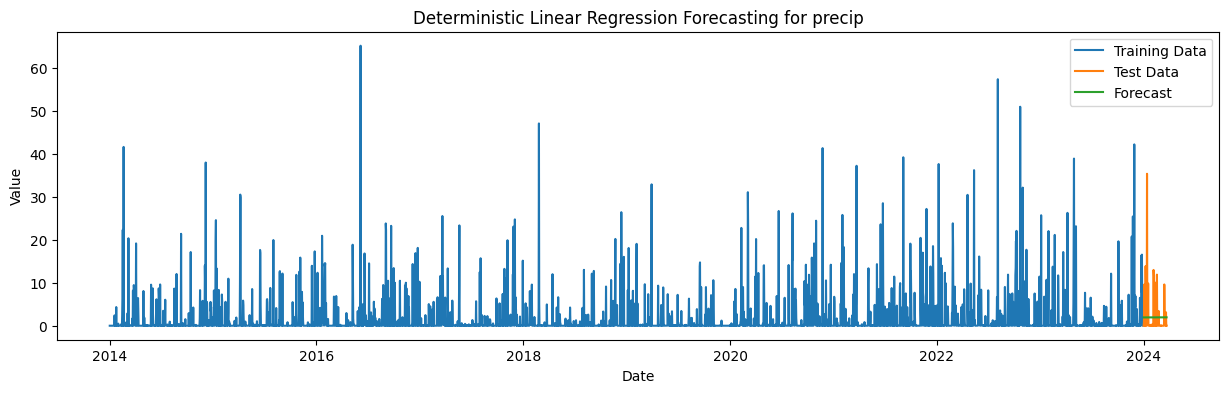

Forecasting feature snow


ValueError: Input contains NaN.

In [23]:
from sklearn.linear_model import LinearRegression

linreg_dict = {}
for feature in forecast_features:
    print(f'Forecasting feature {feature}')
    
    # Split data into train and test
    train_series = weather_clean[feature][:'2023-12-31']
    test_series = weather_clean[feature]['2024-01-01':]
    
    # Calculate linear trend parameters
    x_train = np.arange(len(train_series)).reshape(-1, 1)  # Using indices as x-values
    y_train = train_series.values.reshape(-1, 1)
    
    # Fit linear regression manually
    slope, intercept = np.polyfit(x_train.flatten(), y_train.flatten(), 1)
    
    # Forecast using the deterministic linear function
    forecast_steps = 82
    forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps)
    forecast = intercept + slope * np.arange(len(train_series), len(train_series) + forecast_steps)
    
    # Calculate MAE
    mae = mean_absolute_error(test_series, forecast[:len(test_series)])
    linreg_dict[feature] = mae
    print("Mean Absolute Error:", mae)
    
    # Plotting
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=train_series, label='Training Data')
    sns.lineplot(data=test_series, label='Test Data')
    sns.lineplot(x=forecast_index, y=forecast, label='Forecast')
    plt.title(f'Deterministic Linear Regression Forecasting for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [ ]:
from prophet import Prophet

prophet_dict = {}
for feature in forecast_features:
    print(f'Forecasting feature {feature}')
    
    # Prepare data for Prophet
    df = weather_clean[[feature]].reset_index()
    df.columns = ['ds', 'y']  # Prophet expects columns named 'ds' (datetime) and 'y' (value)
    
    # Split data into train and test
    train_df = df[df['ds'] <= '2023-12-31']
    test_df = df[df['ds'] >= '2024-01-01']
    
    # Fit Prophet model
    model = Prophet()
    model.fit(train_df)
    
    # Make future dataframe for forecasting
    future = model.make_future_dataframe(periods=len(test_df), freq='D', include_history=False)
    
    # Forecast
    forecast = model.predict(future)
    
    # Calculate MAE
    mae = mean_absolute_error(test_df['y'], forecast['yhat'][:len(test_df)])
    prophet_dict[feature] = mae
    print("Mean Absolute Error:", mae)
    
    # Plotting
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=train_df, x='ds', y='y', label='Training Data')
    sns.lineplot(data=test_df, x='ds', y='y', label='Test Data')
    sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast')
    plt.title(f'Prophet Forecasting for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [ ]:
result_arima = pd.DataFrame(arima_dict, index=['arima'])
result_linreg = pd.DataFrame(linreg_dict, index=['linreg'])
result_prophet = pd.DataFrame(prophet_dict, index=['prophet'])

In [ ]:
pd.concat([result_arima, result_linreg, result_prophet]).T.plot(kind='bar')

In [ ]:
def isWorkday(date, workday):
    return (workday & pow(2, date.weekday())) != 0

In [ ]:
weather_all.to_csv('data/weather_all.csv')

In [ ]:
weather_all

In [ ]:
def assessWeather(start_date, end_date, workday, weather_data):
    select_weather = weather_data[start_date:end_date]
    count = 0
    warning = 0
    
    for date, row in select_weather.iterrows():
        if isWorkday(date, workday) :
            if row['heavy_weather'] == 1:
                warning += 1
            count += 1
    
    print(f'There are {count} workdays.')
    print(f'There are {warning} days with potential bad weather.')
    print(f'Severity score {warning/count*100:.2f}')
    
    return warning/count*100
    

In [ ]:
assessWeather('2018-01-01', '2023-02-15',31,weather_all)